In [6]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

import sys
sys.path.append('~/SCALEX/script')
from metrics import *
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

In [3]:
palette = { 'SCALEX': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            'Raw': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            'Seurat_v3': (1.0, 0.4980392156862745, 0.054901960784313725),
            'Harmony':  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            'Conos':(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            'BBKNN': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            'Scanorama': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            'FastMNN':  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            'scVI': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            'online_iNMF':(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            'LIGER':(0.6509803921568628, 0.807843137254902, 0.8901960784313725)}

In [4]:
datasets =['pancreas', 'heart','liver','NSCLC','PBMC']
methods = ['Raw', 'SCALEX','Seurat_v3','Harmony','Conos','BBKNN','scVI','Scanorama','FastMNN','online_iNMF','LIGER']

### Silhouette_score & batch_entropy_mixing_score

In [6]:
datasets = ['pancreas','heart','liver','NSCLC','PBMC']
methods = ['Raw', 'SCALEX','Seurat_v3','Harmony','Conos','BBKNN','scVI','Scanorama','FastMNN','online_iNMF','LIGER']

batch_score = pd.DataFrame(index = datasets, columns = methods)
Silhouette_score = pd.DataFrame(index = datasets, columns = methods)

for dataset in datasets:
    print(dataset)
    adata = sc.read_h5ad('/home/tiankang/SCALEX/results/{}/adata.h5ad'.format(dataset))
    
    batch_id = adata.obs['batch'].values.astype('object')
    celltype = adata.obs['celltype'].values.astype('object').astype('str')
    sample_size = 5000 if adata.shape[0] > 5000 else adata.shape[0]
    for method in methods:
        if method+'_umap' in list(adata.obsm.keys()):
            feature = adata.obsm[method+'_umap']
            feature[np.isnan(feature)] = 0
            Silhouette_score.loc[dataset, method] = (silhouette_score(feature, celltype, sample_size=sample_size,random_state=1367))

        else:
            Silhouette_score.loc[dataset, method] = 0
            pass
    
    df = pd.DataFrame(adata.obs.groupby('celltype')['batch'].nunique())
    Celltypes = list(df[df['batch'] >1].index)
    batch_score1 = []
    for Celltype in Celltypes:
        adata_ = adata[adata.obs.celltype == Celltype]

        batch_id = adata_.obs['batch'].values.astype('object').astype('str')
        celltype = adata_.obs['celltype'].values.astype('object').astype('str')
        
        n_neighbors = 30 if adata_.shape[0] > 30 else adata_.shape[0]
        n_samples_per_pool = 30 if adata_.shape[0] > 30 else adata_.shape[0]

        batch_score2 = []
        for method in methods: 
            if method+'_umap' in adata_.obsm.keys():
                feature = adata_.obsm[method+'_umap']
                feature[np.isnan(feature)] = 0
                    
                batch_score2.append(batch_entropy_mixing_score(feature,
                                                               batch_id,
                                                               n_neighbors = n_neighbors,
                                                               n_pools=10, 
                                                               n_samples_per_pool=n_samples_per_pool
                                                               )*adata_.shape[0])
            else:
                batch_score2.append(0)
                pass
        
        batch_score1.append(batch_score2)
    total = adata[adata.obs.celltype.isin(Celltypes)].shape[0]
    correct = [item/total for item in np.sum(batch_score1, axis=0)]

    batch_score.loc[dataset, :] = correct

In [11]:
score = pd.DataFrame({' Dataset':np.repeat(datasets, len(methods)),
                       'Method': methods * len(datasets),
                       'Silhouette_score': np.reshape(Silhouette_score.values, (1, -1)).squeeze(),
                       'Batch_mixing_score': np.reshape(batch_score.values, (1, -1)).squeeze(),})

No handles with labels found to put in legend.


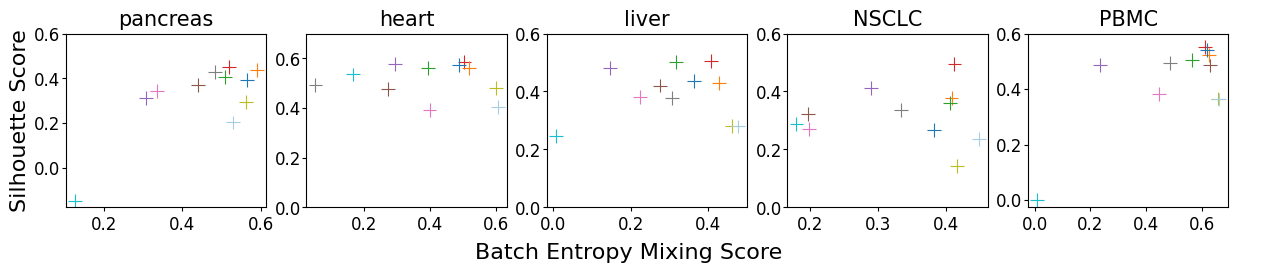

In [15]:
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

from matplotlib import gridspec
figsize=(15,2.3)
fig = plt.figure(figsize=figsize)
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
legend_params_ = {'loc': 'center left',
                  'bbox_to_anchor':(1.05, 0.45),
                  'fontsize': 12,
                  'ncol': 1,
                  'frameon': False,
                  'markerscale': 1.2,
                 }
axs = gridspec.GridSpec(nrows=1, ncols=5, height_ratios=None, width_ratios=[1]*5, wspace=0.2, hspace=0)

for i, data in enumerate(datasets):
    ax = fig.add_subplot(axs[0, i])
    if i == 4:
        ax = sns.scatterplot(x="Batch_mixing_score", 
                             y="Silhouette_score", 
                             data=score.loc[score.Dataset == data,:],
                             hue='Method',
                             palette=palette,
                             legend=False,
                             marker='+',
                             s=100)
        
        plt.legend(**legend_params_)
    else:
        ax = sns.scatterplot(x="Batch_mixing_score", 
                             y="Silhouette_score", 
                             data=score.loc[score.Dataset == data,:],
                             hue='Method',
                             palette=palette, 
                             legend=False,
                             marker="+",
                             s=100)
        
    if i == 1:    
        plt.ylim(0,0.7)
    else:
        ax.set_yticks([0,0.2,0.4,0.6])
    ax.set_title(data, fontsize=15, va='center',pad=10)
    ax.tick_params(axis='y',left=True, right=False, labelright=False, labelleft=True, labelsize=12, length=3, pad=1)


    if i == 0:
        ax.set_ylabel('Silhouette Score', rotation=90, fontsize=16, labelpad=10, va='center')
    else:
        ax.set_ylabel('')

    ax.set_xlabel('', fontsize=15, labelpad=10, va='center')
    ax.tick_params(axis='x', bottom=True, top=False, labeltop=False, labelbottom=True, labelsize=12, length=3, pad=3, labelrotation=0)
fig.text(0.5, -0.1, 'Batch Entropy Mixing Score', ha='center',size=16)